# Introduction to DORIS

## Objectives

* Get a clear view about how the DORIS system works.
* Explore DORIS data and information contained in the RINEX files.
* Familiarize with DORIS measurements concept; beacons/emitters, satellites/receivers, passes.
* Extract observations from a DORIS RINEX file.

## Imports

In [5]:
from dsoclasses.rinex.doris.rinex import DorisRinex
from os.path import join

# set the filename ...
data_path = "/home/xanthos/Software/AcademicSoftware/data"
drinex = join(data_path, "s6arx24001.001")

# construct the instance ...
rnx = DorisRinex(drinex)

## What is the time scale of DORIS (RINEX files) ?

In [6]:
print(f'RINEX reported time system is \"{rnx.time_sys}\"')

RINEX reported time system is "DOR"


Time tags in the RINEX file are reported in 'DORIS' time scale, which is aligned to TAI. Hence, in practice, we consider the RINEX tags to be in (a realization of) TAI.

## What are the nominal DORIS frequencies ?

DORIS transmits on two fundamental frequencies:
 - S1 at 2036.25 MHz ($\approx 15$cm), and
 - U2 at 401.25 ($\approx 75$cm) MHz

Beacon frequencies can be different than the nomial and depend on a "shift factor" $k$, reported in the RINEX file(s).
```text
D37  TLSB TOULOUSE                      10003S005  4   0    STATION REFERENCE   
D38  GR4B GRASSE                        10002S019  4 -15    STATION REFERENCE   
D39  BETB BETIO                         50305S001  3   0    STATION REFERENCE   
D40  NOXC NOUMEA                        92701S005  4   0    STATION REFERENCE   
D41  OWFC OWENGA                        50253S002  4   0    STATION REFERENCE   
D42  ASEB ASCENSION                     30602S005  3   0    STATION REFERENCE   
D43  TSTC TEST-FERMAT                   10003S006  4 -22    STATION REFERENCE 
```

To compute a beacon's nominal frequency, we use the formulae:
$$
    S1(k) = 543 \times USO_{F0} \times 0.75e0 + 543 \times USO_{F0} \times 87 \times k / (5 \times 2^26)
$$
and
$$
    U2(k) = 107 \times USO_{F0} \times 0.75 + 107 \times USO_{F0} \times 87 \times k / (5 \times 2^26)
$$
where $USO_{F0} = 5\times 10^6$; note that for $k=0$ the above results in the fundamental frequencies S1 and U2.

The above computation can be performed by loading:
```python
from dsoclasses.doris.algorithms import beacon_nominal_frequency
s1,u2 = beacon_nominal_frequency(k)
```

Given the RINEX above, what would the transmitted frequencies be for TLSB, GR4B and TSTC ?

In [7]:
from dsoclasses.doris.algorithms import beacon_nominal_frequency

s1,u2 = beacon_nominal_frequency(0)
print(f'TLSB nominal frequencies: {s1*1e-6:.2f} and {u2*1e-6:.2f} MHz')
s1,u2 = beacon_nominal_frequency(-15)
print(f'GR4B nominal frequencies: {s1*1e-6:.2f} and {u2*1e-6:.2f} MHz')
s1,u2 = beacon_nominal_frequency(-22)
print(f'TSTC nominal frequencies: {s1*1e-6:.2f} and {u2*1e-6:.2f} MHz')

TLSB nominal frequencies: 2036.25 and 401.25 MHz
GR4B nominal frequencies: 2036.24 and 401.25 MHz
TSTC nominal frequencies: 2036.23 and 401.25 MHz


## What does each beacon contribute to the observations ?

Let's extract e.g. C1 observations that are performed w.r.t the beacon DIOB:

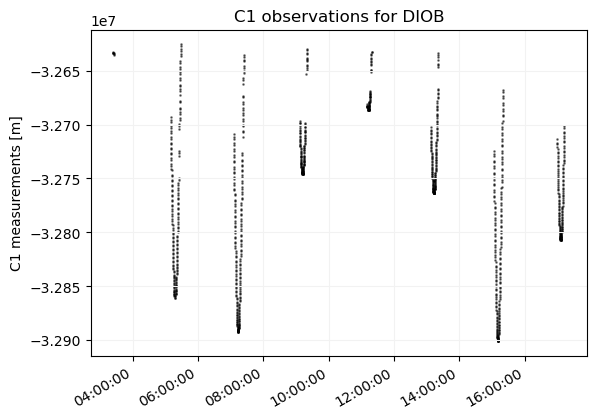

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from dsoclasses.time.pyattotime import at2pt

# get the internal id of the 'DIOB' beacon:
site_id = rnx.name2id('DIOB')

# store measurements here (time, C1)
t = []; C1 = [];

# only consider one day of measurements, so we can have a clearer view
t0 = rnx.time_first_obs

# for every block in RINEX ...
for block in rnx:
    # stop if we reached next day
    if (block.t()-t0).total_seconds() > 86400: break
    # for every beacon in the (current) data block ...
    for beacon, data in block:
        # match the site
        if beacon == site_id:
            # got DIOB! store the data
            t.append(block.t())
            C1.append(data['C1']['value'])

# plot results
plt.scatter([at2pt(ti) for ti in t], C1, color='black', alpha=0.5, s=.8)
plt.grid(color='0.95')
plt.ylabel("C1 measurements [m]")
plt.title("C1 observations for DIOB")
# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()
plt.show()

## How does a site 'see' the passing satellite(s) ?

To see how a DORIS beacon observes a satellite, we can create a skyplot.

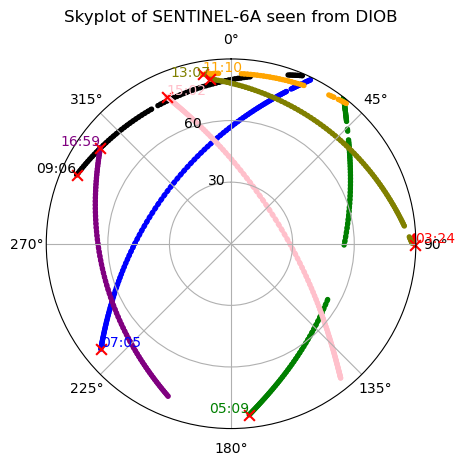

In [9]:
from dsoclasses.sinex import sinex
from dsoclasses.geodesy import transformations
from dsoclasses.orbits.interpolator import Sp3Interpolator
from os.path import join
import datetime

# we need an sp3/interpolator to get satellite position
dsp3 = join(data_path, "ssas6a20.b23357.e24001.DG_.sp3.001")
intrp = Sp3Interpolator.from_sp3(dsp3, ['L'], interval_in_sec=310, min_data_pts=10, itype='Barycentric')

# get the internal id of the 'DIOB' beacon:
site_id = rnx.name2id('DIOB')

# get coordinates for the beacon from a dpod file; store into a numpy array
dpod = join(data_path, "dpod2020_041.snx")
dpod_freq_corr = join(data_path, "dpod2020_041_freq_corr.txt")
result = sinex.extract_sinex_coordinates(dpod, ['DIOB'], rnx.time_first_obs, True, dpod_freq_corr)
diob_xyz = np.array([result['DIOB']['X'], result['DIOB']['Y'], result['DIOB']['Z']])

# R: rotation matrix from cartesian to topocentric, centered on DIOB
lat, lon, hgt = transformations.car2ell(*diob_xyz)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

# We seem to have several passes over the beacon, each one should be plotted with a different color.
c=['red','green','blue','black','orange', 'olive', 'pink', 'purple', 'brown', 'gray']

# data to plot (different colors for each pass)
azs = []; els = []; colors = [];

# coordinates and time of new entries/passes
entries_az = []; entries_el = []; entries_t = [];

# current color index
color_idx = -1
last_epoch = datetime.datetime.min

# for every block in RINEX ...
for block in rnx:
    # stop if we reached next day
    if (block.t()-rnx.time_first_obs).total_seconds() > 86400: break
    # for every beacon in the (current) data block ...
    for beacon, data in block:
        # match the site
        if beacon == site_id:         
            # got DIOB; get satellite position
            x, y, z, _ = intrp.sat_at('L40', block.t())
            # beacon to satellite vector
            dr = np.array([x, y, z]) - diob_xyz
            # get topocentric coordinates
            enu = R @ dr
            # compute range, azimouth and elevation
            r  = np.linalg.norm(enu)
            az = np.arctan2(enu[0], enu[1])
            el = np.arcsin(enu[2] / r)
            # append new point in spherical coordinates, azimout and elevation
            azs.append(az)
            els.append(90e0 - np.degrees(el))
            # if we are at a new pass, change color and mark as entry point
            if (at2pt(block.t())-last_epoch).total_seconds()>3600:
                color_idx += 1
                entries_az.append(az)
                entries_el.append(90e0 - np.degrees(el))
                entries_t.append(at2pt(block.t()))
            colors.append(c[color_idx])
            last_epoch = at2pt(block.t())

# Create the skyplot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# position markers
ax.scatter(azs, els, c=colors, s=8)
# mark entry points with 'x'
ax.scatter(entries_az, entries_el, marker='x', c='red', s=60, clip_on=False)
# time of entry
for i in range(len(entries_t)):
    ax.text(entries_az[i], entries_el[i], entries_t[i].strftime("%H:%M"),
    fontsize=10, ha='right' if (i%2)!=0 else 'left', va='bottom', clip_on=False, color=c[i])
ax.set_rmax(90)
ax.set_rticks([30, 60])
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

# Rotate the angle axis by -90 degrees (make 0 degrees point up)
ax.set_theta_zero_location('N')  # Set 0 to the top (North)
ax.set_theta_direction(-1)  # Make the angles increase clockwise

ax.set_title(f"Skyplot of {rnx.sat_name} seen from DIOB", va='bottom')
plt.show()

## GroundTrack - Which part of the trajectory are we observing ?

Groundtrack is essentially the projection of the satellite trajectory on a map. Using the sp3 file we can plot the groundtrack, and keep track of the part we can observe from the beacon (assuming a totalyy clear horizon).

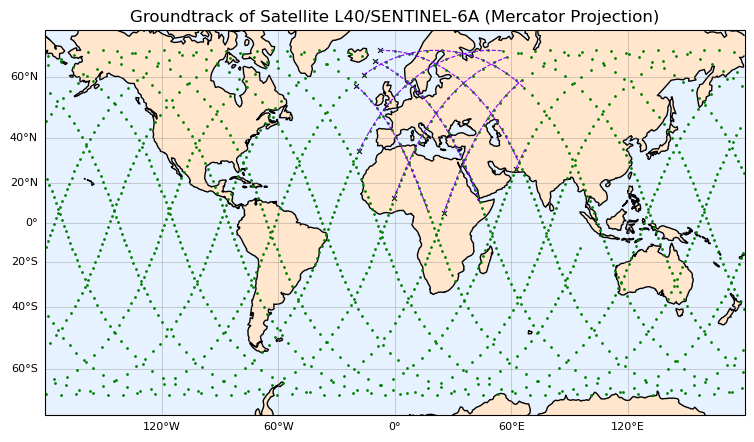

In [10]:
# groundtrack

# we will need to extract satellite position from sp3
from dsoclasses.orbits.sp3c import Sp3

# import modules for projections
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# all points vs observed points vs entry points
sat_pts = []
observed_pts = {}
entry_pts = []
last_elevation = -1.

# construct an sp3 instance and extract the (only) satellite's data
sp3 = Sp3(dsp3)
# set the id of the satellite we need; it should be the first (and only) satellite in the sp3 list
satid = sp3.sat_ids[0]
# extract its data
sp3_data = sp3.get_satellite(satid, True)
# this is what an entry of sp3_data looks like:
# key  : 2023-12-23 01:20:00 
# value: {'x': 3424775.359, 'y': -633803.9230000001, 'z': -6885685.5649999995, 
#         'c': 0.9999999999989999, 'vx': -1616.6218860000001, 
#        'vy': 6616.007571200001, 'vz': -1412.3204711, 'cr': 0.9999999999989999}

for t, crd in sp3_data.items():
        # we are only considering the first 24 hours after the first RINEX observation
        if t >= at2pt(rnx.time_first_obs):
            if (t-at2pt(rnx.time_first_obs)).total_seconds() > 86400:
                break
            # compute and store satellite's lat/lon
            lat, lon, _ = transformations.car2ell(crd['x'], crd['y'], crd['z'])
            sat_pts.append((lon, lat))
            # do we see the satellite standing on DIOB ?
            dr = np.array([crd['x'], crd['y'], crd['z']]) - diob_xyz
            # get topocentric coordinates
            enu = R @ dr
            r  = np.linalg.norm(enu)
            el = np.degrees(np.arcsin(enu[2] / r))
            if el >= 0:
                if last_elevation < 0:
                    entry_pts.append((lon, lat))
                    pass_nr = len(observed_pts)
                    observed_pts[pass_nr] = []
                observed_pts[pass_nr].append((lon, lat))
            last_elevation = el

# Create the Mercator projection
proj = ccrs.Mercator()

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=proj)

# Set map extent: (lon_min, lon_max, lat_min, lat_max)
ax.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())

# Add map features
ax.coastlines(resolution='110m')  # '110m' = crude
ax.add_feature(cfeature.LAND, facecolor='#ffe6cc')
ax.add_feature(cfeature.OCEAN, facecolor='#e6f2ff')

# Gridlines (parallels and meridians)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
gl.top_labels = gl.right_labels = False  # only show left and bottom labels
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# Convert and plot satellite positions
ax.plot([np.degrees(p[0]) for p in sat_pts], [np.degrees(p[1]) for p in sat_pts], 'go', markersize=1, transform=ccrs.PlateCarree())
# Convert and plot viewed satellite positions, each with a different color
for ps, d in observed_pts.items():
    ax.plot([np.degrees(p[0]) for p in d], [np.degrees(p[1]) for p in d], linestyle='--', linewidth=.8, markersize=0, color='#8000ff', transform=ccrs.PlateCarree())
# Convert and plot entry satellite positions
ax.scatter([np.degrees(p[0]) for p in entry_pts], [np.degrees(p[1]) for p in entry_pts],s=12,marker='x',c='k',linewidths=0.8,transform=ccrs.PlateCarree(),)

# Title
plt.title(f"Groundtrack of Satellite {satid}/{rnx.sat_name} (Mercator Projection)")

plt.show()

## How do we form Doppler observations ?

Doppler Range-Rate observations are formed by differencing two adjacent phase measurements (at the same frequency). In a simplistic approach, this reads:
$$ \frac{\Delta \phi}{\Delta t} \lambda = \frac{\phi (t_2) - \phi (t_1)}{\Delta t} \cdot \frac{c}{f} \approx \frac{\rho (t_2) - \rho (t_1)}{\Delta t} \approx \dot{\rho} $$ in units of $m/sec$ where:

- $\phi (t_i)$ is the carrier wave phase observation at instant $t_i$,
- $\Delta t$ time interval, in seconds, between $t_2$ and $t_1$,
- $c$ speed of light,
- $f$ (nominal) frequency, and
- $\rho _{t_i}$ range (satellite-beacon distance) at $t_i$

Based on the above formula, we can go on to compute observation residuals. We need to compute the ranges between the selected site and the satellite; for the latter, we can retrieve its position at the epochs of request using the interpolatator declared above (`intrp`). We are going to extrapolate site coordinates using the dpod file and use the DORIS RINEX file already in use (`rnx`) to extract observations.

In [11]:
# speed of light
C = 299792458e0

dpod = join(data_path, "dpod2020_041.snx")
dpod_freq_corr = join(data_path, "dpod2020_041_freq_corr.txt")

# extract site coordinates into an array
result = sinex.extract_sinex_coordinates(dpod, ['DIOB'], rnx.time_first_obs, True, dpod_freq_corr)
rsite  = np.array([result['DIOB']['X'], result['DIOB']['Y'], result['DIOB']['Z']])

# info of previous measurement
tai_prev = None   # time
range_prev = None # range at tai_prev
L2GHz_prev = None # phase measurement at 2GHz at tai_prev

# nominal frequency for site beacon (only if k=0 for now) in Hz
S1, U2 = beacon_nominal_frequency(rnx.kfactor('DIOB'))
assert rnx.kfactor('DIOB') == 0

# lets store time and range-rate measurements to plot them later on
ts = []; res = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id('DIOB'):
            # measurement epoch
            tai = block.t()
            # satellite position
            satx, saty, satz, _ = intrp.sat_at('L40', tai)
            rsat = np.array([satx, saty, satz])
            # range
            range = np.linalg.norm(rsat-rsite)
            # L2GHz measurement
            L2GHz = data['L1']['value']
            # see if we have a previous measurement which is up to 10 sec away
            if tai_prev is None or (tai-tai_prev).total_seconds() > 11:
                pass
            else:
                # form Doppler observation
                dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9
                rest = ((L2GHz - L2GHz_prev)/dt) * (C/S1) - (range - range_prev)/dt
                # harsh outlier detection
                if abs(rest) < 100.:
                    ts.append(tai)
                    res.append(rest)
            # update info of previous measurement
            tai_prev = tai
            range_prev = range
            L2GHz_prev = L2GHz

print(f'Residual mean={np.mean(res):.1f} and std. deviation={np.std(res):.2f}')

Residual mean=21.4 and std. deviation=10.10


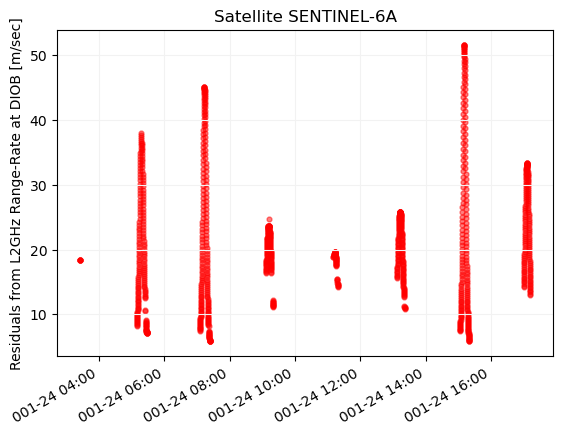

In [12]:
plt.scatter([at2pt(ti) for ti in ts], res, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L2GHz Range-Rate at DIOB [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%j-%y %H:%M"))
plt.gcf().autofmt_xdate()
plt.show()

# System Biases [Optional: included in Observation Equation Session]

## Receiver Clock Error

Clock synchronization errors are very important in every satellite technique where time is measured by a different oscillator at the two ends (receiver/beacon). In the case of DORIS RINEX, the receiver (satellite) clock error w.r.t. DORIS system time (i.e. TAI) is reported for each block. We can use this value to 'correct' our observations from the clock error at the receiver end. Note that a similar error at the transmitting end (i.e. the beacon) can only be estimated.

Let's go on and remove this error to see its effect on the residuals.

Residual mean=4.2 and std. deviation=0.12


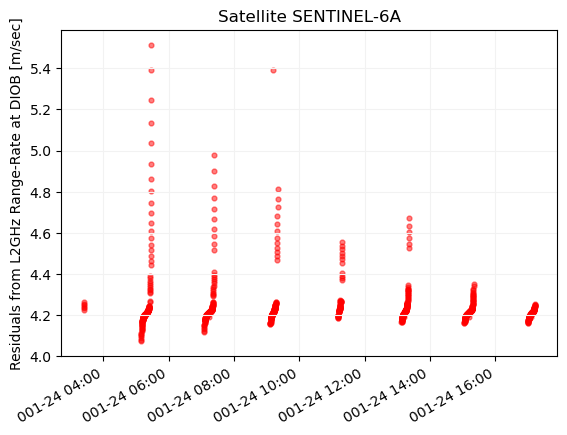

In [13]:
# import attotime for augmenting time precision
import attotime

# info of previous measurement
tai_prev = None   # time
range_prev = None # range at tai_prev
L2GHz_prev = None # phase measurement at 2GHz at tai_prev

# lets store time and range-rate measurements to plot them later on
ts = []; res = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id('DIOB'):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)
            
            # satellite position
            satx, saty, satz, _ = intrp.sat_at('L40', tai)
            rsat = np.array([satx, saty, satz])
            # range
            range = np.linalg.norm(rsat-rsite)
            # L2GHz measurement
            L2GHz = data['L1']['value']
            # see if we have a previous measurement which is up to 10 sec away
            if tai_prev is None or (tai-tai_prev).total_seconds() > 11:
                pass
            else:
                # form Doppler observation
                dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9
                rest = ((L2GHz - L2GHz_prev)/dt) * (C/S1) - (range - range_prev)/dt
                # harsh outlier detection
                if abs(rest) < 100.:
                    ts.append(tai)
                    res.append(rest)
            # update info of previous measurement
            tai_prev = tai
            range_prev = range
            L2GHz_prev = L2GHz
            
print(f'Residual mean={np.mean(res):.1f} and std. deviation={np.std(res):.2f}')

plt.scatter([at2pt(ti) for ti in ts], res, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L2GHz Range-Rate at DIOB [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%j-%y %H:%M"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()
plt.show()

## Nominal and True Frequencies [Optional: included in Observation Equation Session]

When accuracy is needed, one can distinguish between **true** and **nominal** receiver/transmitter frequencies. Theoretically, both ends should transmit/receive at nominal frequencies but this is not the case due to small hardware effects. RINEX files provide *relative frequency offset of the receiver's oscillator*, i.e. $F=\frac{f_{rT}-f_{rN}}{f_{rN}}$ tagged as observation type 'F', for each epoch, scaled by $10^{11}$. We can use these values to modify the equation as:
$$
(\frac{\phi (t_2) - \phi (t_1)}{\Delta t} + f_{rT} - f_{eN}) \cdot \frac{c}{f_{eN}} 
\approx \frac{\rho (t_2) - \rho (t_1)}{\Delta t}
$$

Here are the F values reported in the RINEX file:

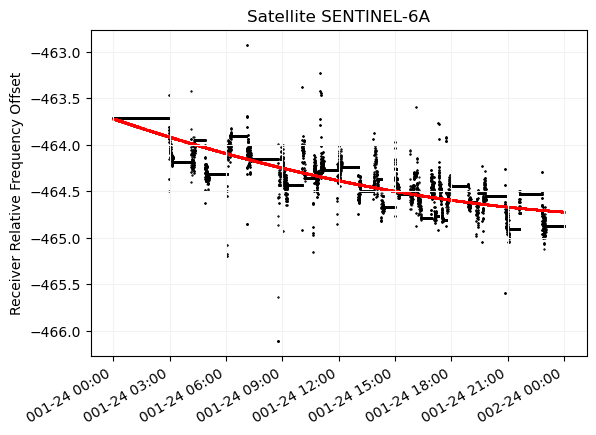

In [16]:
ts = []; Fs = [];

for block in rnx:
    for beacon, data in block:
            ts.append( block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9) )
            Fs.append( data['F']['value'] )

plt.scatter([at2pt(ti) for ti in ts], Fs, alpha=0.5, s=.2, c='black')
plt.grid(color='0.95')
plt.ylabel("Receiver Relative Frequency Offset")
plt.title(f"Satellite {rnx.sat_name}")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%j-%y %H:%M"))
plt.gcf().autofmt_xdate()

# fit a seconds degree polynomial
dfpln_t0 = ts[0]
t = [float((t-dfpln_t0).total_nanoseconds())*1e9 for t in ts]
dfpln = np.poly1d(np.polyfit(t, Fs, 2))
def dfreq(t):
    return dfpln(float((t-dfpln_t0).total_nanoseconds())*1e9)

plt.scatter([at2pt(ti) for ti in ts], [dfreq(ti) for ti in ts], alpha=0.5, s=.1, c='red')
plt.show()

Residual mean=2.8 and std. deviation=0.12


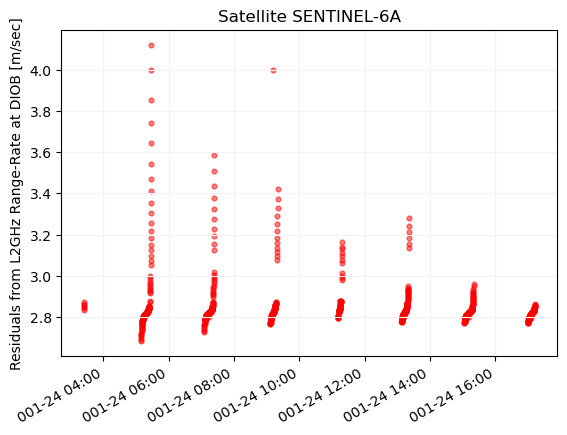

In [15]:
frN = S1
feN, _ = beacon_nominal_frequency(rnx.kfactor('DIOB'))

# info of previous measurement
tai_prev = None   # time
range_prev = None # range at tai_prev
L2GHz_prev = None # phase measurement at 2GHz at tai_prev

# lets store time and range-rate measurements to plot them later on
ts = []; res = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id('DIOB'):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)
            
            # satellite position
            satx, saty, satz, _ = intrp.sat_at('L40', tai)
            rsat = np.array([satx, saty, satz])
            # range
            range = np.linalg.norm(rsat-rsite)
            # L2GHz measurement
            L2GHz = data['L1']['value']
            # see if we have a previous measurement which is up to 10 sec away
            if tai_prev is None or (tai-tai_prev).total_seconds() > 11:
                pass
            else:
                # form Doppler observation
                dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9
                # 'true' receiver frequency
                # frT = data['F']['value']*1e-11 * S1 + S1
                # or
                frT = dfreq(tai)*1e-11 * S1 + S1
                # observed range-rate
                v_obs = -(C/feN) * (feN - frT - (L2GHz - L2GHz_prev)/dt)
                # computed range-rate
                v_cmp = (range - range_prev)/dt
                # harsh outlier detection
                if abs(v_obs-v_cmp) < 100.:
                    ts.append(tai)
                    res.append(v_obs-v_cmp)
            # update info of previous measurement
            tai_prev = tai
            range_prev = range
            L2GHz_prev = L2GHz
            
print(f'Residual mean={np.mean(res):.1f} and std. deviation={np.std(res):.2f}')

plt.scatter([at2pt(ti) for ti in ts], res, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L2GHz Range-Rate at DIOB [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%j-%y %H:%M"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()
plt.show()